# Train a ready to use PyTorch model with a simple pipeline

In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

sys.path.append("../..")
from batchflow import Pipeline, B, C, D, F, V
from batchflow.opensets import MNIST, CIFAR10, CIFAR100
from batchflow.models.torch import VGG7

BATCH_SIZE might be increased for modern GPUs with lots of memory (4GB and higher).

In [2]:
BATCH_SIZE = 64

# Create a dataset

[MNIST](http://yann.lecun.com/exdb/mnist/) is a dataset of handwritten digits frequently used as a baseline for machine learning tasks.

Downloading MNIST database might take a few minutes to complete.

In [3]:
dataset = MNIST(bar=True)

100%|██████████| 8/8 [00:01<00:00,  2.02it/s]


There are also predefined CIFAR10 and CIFAR100 datasets.

# Define a pipeline config

Config allows to create flexible pipelines which take parameters.

For instance, if you put a model type into config, you can run a pipeline against different models.

See [a list of available models](https://analysiscenter.github.io/batchflow/intro/torch_models.html#ready-to-use-models) to choose the one which fits you best.

In [4]:
config = dict(model=VGG7)

Define function to plot the loss graph.

In [5]:
def plot_loss(loss):
    plt.figure(figsize=(15, 5))
    plt.plot(loss)
    plt.xlabel("Iterations"), plt.ylabel("Loss")
    plt.show()

# Create a template pipeline

A template pipeline is not linked to any dataset. It's just an abstract sequence of actions, so it cannot be executed, but it serves as a convenient building block.

In [6]:
train_template = (Pipeline()
                  .init_variable('loss_history', [])
                  .init_model('dynamic', C('model'), 'conv_nn',
                              config={'inputs/images/shape': B.image_shape,
                                      'inputs/labels/classes': D.num_classes,
                                      'initial_block/inputs': 'images'})
                  .to_array(channels='first', dtype='float32')
                  .train_model('conv_nn', B.images, B.labels,
                               fetches='loss', save_to=V('loss_history', mode='a'), use_lock=True)
)

In [7]:
(train_template.after
 .plot_loss(V.loss_history))

# Train the model

Apply a dataset and a config to a template pipeline to create a runnable pipeline:

In [8]:
train_pipeline = (train_template << dataset.train) << config

Run the pipeline (it might take from a few minutes to a few hours depending on your hardware)

100%|██████████| 937/937 [04:31<00:00,  3.32it/s]


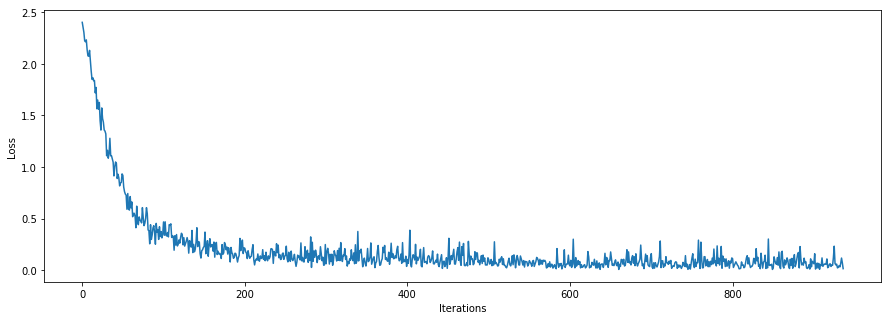

In [9]:
train_pipeline.run(BATCH_SIZE, shuffle=True, n_epochs=1, drop_last=True, bar=True, prefetch=1)

Note that the progress bar often increments by 2 at a time - that's prefetch in action.

It does not give much here, though, since almost all time is spent in model training which is performed under a thread-lock one batch after another without any parallelism (otherwise the model would not learn anything as different batches would rewrite one another's model weights updates).

# Test the model

It is much faster than training, but if you don't have GPU it would take some patience.

In [10]:
test_pipeline = (dataset.test.p
                .to_array(channels='first', dtype='float32')
                .predict_model('conv_nn', B.images,
                               fetches='predictions', save_to=V('predictions'))
                .gather_metrics('class', targets=B.labels, predictions=V('predictions'),
                                fmt='logits', axis=-1, save_to=V('metrics', mode='a'))
)

In [11]:
(test_pipeline.before
 .init_variables('metrics', 'predictions')
 .import_model('conv_nn', train_pipeline))

In [12]:
test_pipeline.run(BATCH_SIZE, shuffle=True, n_epochs=1, drop_last=False, bar=True)

100%|██████████| 157/157 [00:19<00:00,  8.24it/s]


Let's get the accumulated [metrics information](https://analysiscenter.github.io/batchflow/intro/models.html#model-metrics)

In [13]:
metrics = test_pipeline.get_variable('metrics')

Or a shorter version: `metrics = test_pipeline.v('metrics')`

Now we can easiliy calculate any metrics we need

In [14]:
metrics.evaluate('accuracy')

0.9923367834394905

In [15]:
metrics.evaluate(['false_positive_rate', 'false_negative_rate'], multiclass=None)

{'false_negative_rate': array([0.0058993 , 0.00176929, 0.01235467, 0.00398847, 0.00127389,
        0.01141947, 0.01292084, 0.01040087, 0.01172554, 0.01042109]),
 'false_positive_rate': array([0.00044512, 0.00088472, 0.00097797, 0.0006447 , 0.00145556,
        0.00054196, 0.00043593, 0.00121031, 0.00156502, 0.00033396])}

# Save the model
After learning the model, you may need to save it. It's easy to do this.

In [16]:
train_pipeline.save_model_now('conv_nn', path='path/to/model.torch')

## What's next?

See [the image augmentation tutorial](./06_image_augmentation.ipynb) or return to the [table of contents](./00_description.ipynb).